# Wine reviews analysis

## Table of contents <a class="anchor" id="toc">
* [1. Overview of dataset](#dataset-overview)
    * [1.1 Variables overview](#variables-overview)
* [2. Goal of analysis](#goal-of-analysis)
* [3. Data insights and cleaning](#data-insights-and-cleaning)
    * [3.1 First insights](#first-insights)
    * [3.2 Imputation and cleaning](#imputation-and-cleaning)
* [4. Additional features](#additional-features)
    * [4.1 Reviewer's count of followers on Twitter](#twitter-followers)
    * [4.2 Analysis of keywords in descriptions](#description-keywords)
* [5. Dummies for categorical variables](#dummies-for-categorical)
* [6. Predictions](#predictions)
    * [6.1 Points](#points)
    * [6.2 Price](#price)
* [7. Conclusions and further actions](#conclusions)

## 1. Overview of dataset <a class="anchor" id="dataset-overview">
[Back to Table of Contents](#toc)

Dataset used is taken from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews): *winemag-data-130k-v2.csv*. As pointed by author, it is scraped from [Wine Enthusiast](https://www.winemag.com/) website and contains wine decriptions by tasters, prices and scores granted by experts.

Description of reviewing and scoring methodology (provided on website of every wine, for example [here](https://www.winemag.com/buying-guide/nicosia-2013-vulka-bianco-white-etna/)):

<font color='grey'><i>
**Tasting Methodology and Goals**
All tastings reported in the Buying Guide are performed blind. Typically, products are tasted in peer-group flights of from 5–8 samples. Reviewers may know general information about a flight to provide context—vintage, variety or appellation—but never the producer or retail price of any given selection. When possible, products considered flawed or uncustomary are retasted.

**About the Scores**
Ratings reflect what our editors felt about a particular product. Beyond the rating, we encourage you to read the accompanying tasting note to learn about a product’s special characteristics.

|Score|Value|Description|
|-----|-----------|-----------|
|98–100|Classic|The pinnacle of quality.|
|94–97|Superb|A great achievement.|
|90–93|Excellent|Highly recommended.|
|87–89|Very Good|Often good value; well recommended.|
|83–86|Good|Suitable for everyday consumption; often good value.|
|80–82|Acceptable|Can be employed in casual, less-critical circumstances.|

Products deemed Unacceptable (receiving a rating below 80 points) are not reviewed.
</i></font>

### 1.1 Variables overview <a class="anchor" id="variables-overview">
[Back to Table of Contents](#toc)
    
*From [Kaggle](https://www.kaggle.com/zynicide/wine-reviews)*

|Variable|Description|
|-----|-----------|
|country|The country that the wine is from|
|description||
|designation|The vineyard within the winery where the grapes that made the wine are from|
|points|The number of points WineEnthusiast rated the wine on a scale of 1-100|
|price|The cost for a bottle of the wine|
|province|The province or state that the wine is from|
|region_1|The wine growing area in a province or state|
|region_2|Sometimes there are more specific regions specified within a wine growing area|
|taster_name||
|taster_twitter_handle||
|title|The title of the wine review, which often contains the vintage if you're interested in extracting that feature
|variety|The type of grapes used to make the wine|
|winery|The winery that made the wine|

## 2. Goal of analysis<a class="anchor" id="goal-of-analysis">
[Back to Table of Contents](#toc)

Using data provided (including description), try to predict wine price and wine score.

## 3. Data insights and cleaning<a class="anchor" id="data-insights-and-cleaning">

### 3.1 First insights<a class="anchor" id="first-insights">
[Back to Table of Contents](#toc)

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from IPython.display import Markdown as md
from bs4 import BeautifulSoup
import unicodedata
import json
%matplotlib inline

In [2]:
# Import data
wine_data = pd.read_csv('winemag-data-130k-v2.csv', index_col = 0)
wine_data.head(3)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [3]:
# Get insights of data shape
# wine_data.describe(include='all')

In [4]:
# Function for summary on DF
def dataSummary(data):
    eda_dict = {
            'record_count': data.count() + data.isnull().sum()
            , 'column_type': data.dtypes
            , 'unique_count': data.nunique()
            , 'nonmissing_count': data.count()
            , 'missing_count': data.isnull().sum()
            , 'missing_perc': round(data.isnull().sum() / (data.count() + data.isnull().sum()) * 100, 2)
            }
    eda_data = pd.concat(eda_dict, axis = 1)
    return eda_data

In [5]:
# Get insights of data
eda_wine_data = dataSummary(wine_data)
eda_wine_data

,record_count,column_type,unique_count,nonmissing_count,missing_count,missing_perc
country,129971,object,43,129908,63,0.05
description,129971,object,119955,129971,0,0.00
designation,129971,object,37979,92506,37465,28.83
points,129971,int64,21,129971,0,0.00
price,129971,float64,390,120975,8996,6.92
province,129971,object,425,129908,63,0.05
region_1,129971,object,1229,108724,21247,16.35
region_2,129971,object,17,50511,79460,61.14
taster_name,129971,object,19,103727,26244,20.19
taster_twitter_handle,129971,object,15,98758,31213,24.02


Data above points the following:
* There are 129971 records in dataset
* Only 120975 records contain price - one of our targets
* Every record has description, points, title and winery filled; other variables have missings

Will take a look on all variables one by one in order to clean, impute missings and possibly get new features

## 3.2 Imputation and cleaning<a class="anchor" id="imputation-and-cleaning">
[Back to Table of Contents](#toc)

In [6]:
# Function for summary on variable
def varCountDistStats(data, var_name, n_return = 10):
    eda_dict = {
            'record_count': data.groupby([var_name])[var_name].count()
            , 'record_perc': round(data.groupby([var_name])[var_name].count() / (data[var_name].count()) * 100, 1)
            }
    eda_data = pd.concat(eda_dict, axis = 1, sort = False)
    return eda_data.sort_values('record_count', ascending = False).head(n_return)

### 3.2.1 Price

As price is one of our target variables, it is important to have it for all records. Above we've seen, that almost 7% of data has no price filled. Lets discover nature of missing records and decide wheteher they could be dropped for further calculations.

Let's take a look on points histogram depending on price availability. 

In [7]:
# Make missing price flag
wine_data['has_missing_price'] = np.where(wine_data['price'].isna(), 'No price', 'Has price')

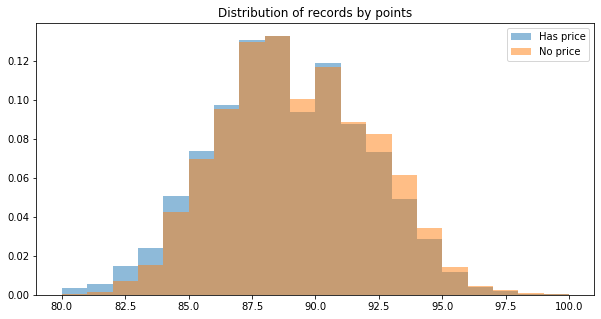

In [8]:
plt.figure(figsize=(10,5))
bins = np.linspace(80, 100, 21)
plt.hist(wine_data[wine_data['has_missing_price'] == 'Has price']['points'], bins, label='Has price', density = True, alpha = 0.5)
plt.hist(wine_data[wine_data['has_missing_price'] == 'No price']['points'], bins, label='No price', density = True, alpha = 0.5)
plt.legend(loc = 'upper right')
plt.title('Distribution of records by points')
plt.show()

Distributions of records with and without price are very similar. Letš find if there are differencies by country.

In [9]:
wine_by_country = pd.concat({
                            'record_count': wine_data.groupby(['country'])['country'].count()
                            , 'with_price_percent': wine_data[wine_data['has_missing_price'] == 'Has price'].groupby(['country'])['country'].count() / wine_data.groupby(['country'])['country'].count()
                            , 'no_price_percent': wine_data[wine_data['has_missing_price'] == 'No price'].groupby(['country'])['country'].count() / wine_data.groupby(['country'])['country'].count()
                            }
                        , axis = 1, sort = False).sort_values('record_count', ascending = False)
wine_by_country.fillna(0, inplace = True)
wine_by_country.head()

,record_count,with_price_percent,no_price_percent
country,,,
US,54504,0.995615,0.004385
France,22093,0.804599,0.195401
Italy,19540,0.865609,0.134391
Spain,6645,0.989165,0.010835
Portugal,5691,0.856616,0.143384


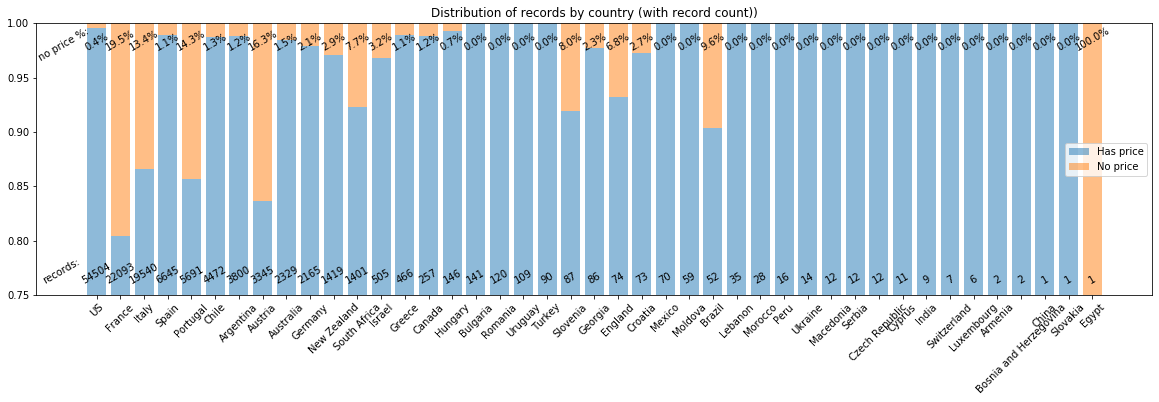

In [10]:
plt.figure(figsize=(20,5))
plt.bar(wine_by_country.index, wine_by_country['with_price_percent'], label = 'Has price', alpha = 0.5)
plt.bar(wine_by_country.index, wine_by_country['no_price_percent'], label = 'No price', alpha = 0.5
        , bottom = wine_by_country['with_price_percent'])

for i, v in enumerate(wine_by_country['record_count']):
    plt.text(i, 0.76, str(v), rotation = 30, ha = 'center')
for i, v in enumerate(wine_by_country['no_price_percent']):
    plt.text(i, 0.975, str(round(v*100,1))+'%', rotation = 30, ha = 'center')
plt.text(-1.5, 0.76, 'records:', rotation = 30, ha = 'center')
plt.text(-1.38, 0.965, 'no price %:', rotation = 30, ha = 'center')

plt.ylim((0.75, 1))
plt.xticks(rotation = 45)
plt.legend(loc = 'center right')
plt.title('Distribution of records by country (with record count))')
plt.show()

Data shows, that prices are missing not at random, if divided by country. There are much frequent missings for large represented France, Italy, Portugal and Austria (13-19%) and quite a few for US, Spain, Chile, Argentina, Australia and Germany (2% or less). Reasons for this inconsistency are unknown.

It is obvious, that dataset does not contain all ever existed wines all over the world, therefore dropping of records with no price should not cause problems as data does not represent whole population. Let's drop records with no price and recalculate data shape.

In [11]:
wine_data_with_price = wine_data[wine_data['has_missing_price'] == 'Has price']

In [12]:
# Get insights of data
eda_wine_data_with_price = dataSummary(wine_data_with_price)
eda_wine_data_with_price

,record_count,column_type,unique_count,nonmissing_count,missing_count,missing_perc
country,120975,object,42,120916,59,0.05
description,120975,object,111567,120975,0,0.00
designation,120975,object,35776,86196,34779,28.75
points,120975,int64,21,120975,0,0.00
price,120975,float64,390,120975,0,0.00
province,120975,object,422,120916,59,0.05
region_1,120975,object,1204,101400,19575,16.18
region_2,120975,object,17,50292,70683,58.43
taster_name,120975,object,19,96479,24496,20.25
taster_twitter_handle,120975,object,15,91559,29416,24.32


Let's also check if there is dependancy between points and price.
As there are only few points with price > 1000 USD, let's see graphs limiting axes to 1000 USD for better understanding.

Wines with price > 1000 USD: 14


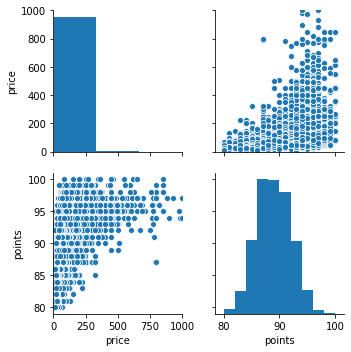

In [13]:
print('Wines with price > 1000 USD:', wine_data_with_price[wine_data_with_price['price'] > 1000]['price'].count())
g = sb.pairplot(wine_data_with_price.loc[:,['price', 'points']])
g.axes[0,0].set_xlim((0,1000))
g.axes[0,0].set_ylim((0,1000));

For sure there is corelation between price and points. There are almost no wines with price >500 USD having score <90 points. Nevertheless, Winemag website states, that wines are evaluated with no background on winery, price etc.

### 3.2.2 Country

In [14]:
# Take a look on most popular countries
varCountDistStats(wine_data_with_price, 'country')

,record_count,record_perc
country,,
US,54265,44.9
France,17776,14.7
Italy,16914,14.0
Spain,6573,5.4
Portugal,4875,4.0
Chile,4416,3.7
Argentina,3756,3.1
Austria,2799,2.3
Australia,2294,1.9


Wines from US, France and Italy cover 74% of all wine records. Let's take a look on records with missings to understand how to impute.

In [15]:
print(eda_wine_data_with_price.loc[['country'],['missing_count', 'missing_perc']])
wine_data_with_price[wine_data_with_price['country'].isnull()].describe(include = 'all')

         missing_count  missing_perc
country             59          0.05


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,has_missing_price
count,0,59,48,59.000000,59.000000,0,0,0,59,59,59,59,59,59
unique,0,55,37,NaN,NaN,0,0,0,8,7,55,31,24,1
top,NaN,"A lively whiff of white blossom, Muscat grapes...",Steirische Klassik,NaN,NaN,NaN,NaN,NaN,Jeff Jenssen,@worldwineguys,Neumeister 2016 Steirische Klassik Gelber Musk...,Red Blend,Neumeister,Has price
freq,NaN,2,6,NaN,NaN,NaN,NaN,NaN,22,34,2,10,9,59
mean,NaN,NaN,NaN,88.745763,24.593220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,1.952834,9.084125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,84.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,88.000000,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,89.000000,25.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,90.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For missing values provinces and regions are also missing. The only field which could help to impute country is winery.

In [16]:
# Get all winery names with missing country
wine_data_with_price[wine_data_with_price['country'].isnull()]['winery'].unique()

array(['Gotsa Family Wines', 'Kakhetia Traditional Winemaking',
       'Tsililis', 'Ross-idi', 'Orbelus', 'St. Donat', 'Familia Deicas',
       'Stone Castle', 'Teliani Valley', 'Undurraga', 'Mt. Beautiful',
       'Neumeister', 'Bachelder', 'Chilcas', 'Santa Ema', 'Psagot',
       'Ktima Voyatzi', 'Lismore', 'Logodaj', 'Somlói Vándor',
       'Les Frères Dutruy', 'El Capricho', 'Amiran Vepkhvadze',
       'Büyülübağ'], dtype=object)

In [17]:
# Create dictionary
# winery: country
winery_country_dict = {
    'Gotsa Family Wines': 'Georgia'
    , 'Kakhetia Traditional Winemaking': 'Georgia'
    , 'Tsililis': 'Georgia'
    , 'Ross-idi': 'Bulgaria'
    , 'Orbelus': 'Bulgaria'
    , 'St. Donat': 'Hungary'
    , 'Familia Deicas': 'Uruguay'
    , 'Stone Castle': 'Albania'
    , 'Teliani Valley': 'Georgia'
    , 'Undurraga': 'Chile'
    , 'Mt. Beautiful': 'New Zealand'
    , 'Neumeister': 'Austria'
    , 'Bachelder': 'Canada'
    , 'Chilcas': 'Chile'
    , 'Santa Ema': 'Chile'
    , 'Psagot': 'Israel'
    , 'Ktima Voyatzi': 'Greece'
    , 'Lismore': 'South Africa'
    , 'Logodaj': 'Bulgaria'
    , 'Somlói Vándor': 'Hungary'
    , 'Les Frères Dutruy': 'Switzerland'
    , 'El Capricho': 'Uruguay'
    , 'Amiran Vepkhvadze': 'Georgia'
    , 'Büyülübağ': 'Turkey'
}

In [18]:
# For further possible usage, create is_imputed_country flag
wine_data_with_price['is_imputed_country'] = wine_data_with_price['country'].isnull()
# Impute country
wine_data_with_price['country'] = wine_data_with_price['country'].fillna(wine_data_with_price['winery'].map(winery_country_dict));

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 3.2.2 Province

In [19]:
# Take a look on most popular provincies
varCountDistStats(wine_data_with_price, 'province')

,record_count,record_perc
province,,
California,36104,29.9
Washington,8583,7.1
Oregon,5359,4.4
Tuscany,5128,4.2
Bordeaux,4002,3.3
Northern Spain,3797,3.1
Mendoza Province,3226,2.7
Burgundy,3106,2.6
Piedmont,3089,2.6


Above (in 'country' section) we saw, that provincies are missing for the same records, where countries did. 
It is much more time consuming to find manually correct provinces for wineries. Let's take a look, whether there are records in initial dataset, where 'country' = 'province'. Perhaps it could be used for simple imputation.

In [20]:
specific_countries = set(winery_country_dict.values())
wine_data_spec_c = wine_data_with_price[wine_data_with_price['country'].isin(specific_countries)]
country_spec_eda_dict = {
        'record_count': wine_data_spec_c.groupby(['country'])['country'].count()
        , 'same_province_record_count': wine_data_spec_c[wine_data_spec_c['province'] == wine_data_spec_c['country']].groupby(['country'])['country'].count()
        , 'same_province_record_perc': round(wine_data_spec_c[wine_data_spec_c['province'] == wine_data_spec_c['country']].groupby(['country'])['country'].count() / wine_data_spec_c.groupby(['country'])['country'].count() * 100, 1)
        }
country_spec_eda_data = pd.concat(country_spec_eda_dict, axis = 1, sort = False)
country_spec_eda_data.sort_values('record_count', ascending = False).head(10)

,record_count,same_province_record_count,same_province_record_perc
Chile,4419,47.0,1.1
Austria,2808,22.0,0.8
New Zealand,1380,12.0,0.9
South Africa,1294,5.0,0.4
Israel,493,14.0,2.8
Greece,463,13.0,2.8
Canada,255,NaN,NaN
Bulgaria,153,9.0,5.9
Hungary,149,7.0,4.7
Uruguay,113,24.0,21.2


Data shows, that initial data contains such records. So let`s impute province with country.

In [21]:
# For further possible usage, create is_imputed_province flag
wine_data_with_price['is_imputed_province'] = wine_data_with_price['province'].isnull()
# Impute province
wine_data_with_price['province'] = wine_data_with_price['province'].fillna(wine_data_with_price['winery'].map(winery_country_dict))

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 3.2.4 Designation, region_1, region_2

No specific ideas how to impute these columns with relevant data. Will impute 'Unknown' value.

In [22]:
# For further possible usage, create is_imputed flags
wine_data_with_price['is_imputed_designation'] = wine_data_with_price['designation'].isnull()
wine_data_with_price['is_imputed_region_1'] = wine_data_with_price['region_1'].isnull()
wine_data_with_price['is_imputed_region_2'] = wine_data_with_price['region_2'].isnull()
# Impute
wine_data_with_price['designation'] = wine_data_with_price['designation'].fillna('Unknown designation')
wine_data_with_price['region_1'] = wine_data_with_price['region_1'].fillna('Unknown region_1')
wine_data_with_price['region_2'] = wine_data_with_price['region_2'].fillna('Unknown region_2');

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### 3.2.5 Variety

In [23]:
# Take a look on most popular varieties
varCountDistStats(wine_data_with_price, 'variety')

,record_count,record_perc
variety,,
Pinot Noir,12787,10.6
Chardonnay,11080,9.2
Cabernet Sauvignon,9386,7.8
Red Blend,8476,7.0
Bordeaux-style Red Blend,5340,4.4
Riesling,4972,4.1
Sauvignon Blanc,4783,4.0
Syrah,4086,3.4
Rosé,3262,2.7


In [24]:
print(eda_wine_data_with_price.loc[['variety'],['missing_count', 'missing_perc']])
wine_data_with_price[wine_data_with_price['variety'].isnull()]

         missing_count  missing_perc
variety              1           0.0


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,has_missing_price,is_imputed_country,is_imputed_province,is_imputed_designation,is_imputed_region_1,is_imputed_region_2
86909,Chile,"A chalky, dusty mouthfeel nicely balances this...",Unknown designation,88,17.0,Maipo Valley,Unknown region_1,Unknown region_2,NaN,NaN,Carmen 1999 (Maipo Valley),NaN,Carmen,Has price,False,False,True,True,True


There is only 1 missing record, let's impute it manually. [Winemag page](https://www.winemag.com/buying-guide/carmen-1999-maipo-valley/) states it's red wine, but has no variety. Let's impute the most popular variety: Pinot Noir.

In [25]:
# For further possible usage, create is_imputed_variety flag
wine_data_with_price['is_imputed_variety'] = wine_data_with_price['variety'].isnull()
# Impute variety
wine_data_with_price['variety'] = wine_data_with_price['variety'].fillna('Pinot Noir');

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 3.2.6 Twitter account

From missing records stats before we've seen that there are records with taster names with no twitter account reference. Let's add this missing info.

In [26]:
# Info from https://www.geeksforgeeks.org/performing-google-search-using-python-code/
# Install google package
# !pip install google
from googlesearch import search
import requests

In [27]:
# Find taster names with no twitter accounts
taster_names = list(set(wine_data_with_price[wine_data_with_price['taster_twitter_handle'].isnull() 
                         & (wine_data_with_price['taster_name'].notnull())]['taster_name']))
taster_names

['Alexander Peartree', 'Carrie Dykes', 'Anna Lee C. Iijima']

In [28]:
# for i in taster_names[0]:
#     query = i + ' site:winemag.com/contributor'
#     for j in search(query, tld='com', lang='en', start=0, stop=1, pause=2.0): 
#         print(j)
#         req = requests.get(j)
#         if req.status_code != 200:
#             print(f'Unexpected status code {req.status_code}. Stopping parse')
#         soup = BeautifulSoup(req.text, 'lxml')

No luck, website has block for python requests. Will need to impute manually (luckily, there are only 3 values to impute).

In [29]:
taster_twitter_accounts_dict = {
    'Carrie Dykes': '@carriedykes1'
    , 'Alexander Peartree': '@apatrone23'
}
# For taster 'Anna Lee C. Iijima' there is no Twiter at all

The only missing values remaining are some reviewer names and their twitters. As they are not specified on website will fill them with 'Unknown' value.

In [30]:
# For further possible usage, create is_imputed flags
wine_data_with_price['is_imputed_twitter'] = wine_data_with_price['taster_twitter_handle'].isnull()
wine_data_with_price['is_imputed_taster_name'] = wine_data_with_price['taster_name'].isnull()
# Impute
wine_data_with_price['taster_twitter_handle'] = wine_data_with_price['taster_twitter_handle'].fillna('Unknown twitter')
wine_data_with_price['taster_name'] = wine_data_with_price['taster_name'].fillna('Unknown taster_name');

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [31]:
# Get insights of data
eda_wine_data_with_price = dataSummary(wine_data_with_price)
eda_wine_data_with_price

,record_count,column_type,unique_count,nonmissing_count,missing_count,missing_perc
country,120975,object,43,120975,0,0.0
description,120975,object,111567,120975,0,0.0
designation,120975,object,35777,120975,0,0.0
points,120975,int64,21,120975,0,0.0
price,120975,float64,390,120975,0,0.0
province,120975,object,424,120975,0,0.0
region_1,120975,object,1205,120975,0,0.0
region_2,120975,object,18,120975,0,0.0
taster_name,120975,object,20,120975,0,0.0
taster_twitter_handle,120975,object,16,120975,0,0.0


No more missings, could continue with additional feature engineering.

## 4. Additional features<a class="anchor" id="additional-features">
[Back to Table of Contents](#toc)

### 4.1 Reviewer's count of followers on Twitter<a class="anchor" id="twitter-followers">
[Back to Table of Contents](#toc)

Idea how to get followers count from https://kaspars.net/blog/twitter-follower-count-without-api

In [32]:
# Find all Twitter accounts in dataset, delete Unknown, remove unicode space, remove @
twitter_accounts = list(set(wine_data_with_price['taster_twitter_handle']))
twitter_accounts = [unicodedata.normalize("NFKD", i)[1:] for i in twitter_accounts if '@' in i]
twitter_accounts

['vossroger',
 'worldwineguys',
 'wawinereport',
 'JoeCz',
 'vboone',
 'paulgwine ',
 'gordone_cellars',
 'laurbuzz',
 'kerinokeefe',
 'wineschach',
 'bkfiona',
 'AnneInVino',
 'suskostrzewa',
 'mattkettmann',
 'winewchristina']

In [33]:
twitter_url_base = 'https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names='

In [34]:
# Check if all Twitter accounts exist
for i in twitter_accounts:
    req = requests.get(twitter_url_base + i)
    if req.status_code != 200:
        print(f'Unexpected status code {req.status_code}. Stopping parse')
    soup = BeautifulSoup(req.text, 'lxml')
    if soup.text == '[]':
        print('Twitter name does not exist, check manually: ', i)

Twitter name does not exist, check manually:  winewchristina


Found out non-existing Twitter account - now it's '@ckpickard'. To replace account name and to add follower count to dictionary.

In [35]:
wine_data_with_price.loc[wine_data_with_price['taster_twitter_handle'] == '@winewchristina', 'taster_twitter_handle'] = '@ckpickard'

C:\Users\jekat\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [36]:
# Find all Twitter accounts once again
twitter_accounts = list(set(wine_data_with_price['taster_twitter_handle']))
twitter_accounts = [unicodedata.normalize("NFKD", i)[1:] for i in twitter_accounts if '@' in i]
twitter_accounts

['vossroger',
 'worldwineguys',
 'wawinereport',
 'JoeCz',
 'vboone',
 'paulgwine ',
 'gordone_cellars',
 'laurbuzz',
 'kerinokeefe',
 'wineschach',
 'bkfiona',
 'AnneInVino',
 'suskostrzewa',
 'mattkettmann',
 'ckpickard']

In [37]:
twitter_dict = dict()
for i in twitter_accounts:
    req = requests.get(twitter_url_base + i)
    if req.status_code != 200:
        print(f'Unexpected status code {req.status_code}. Stopping parse')
    soup = BeautifulSoup(req.text, 'lxml')
    if soup.text == '[]':
        print('Twitter name does not exist, check manually: ', i)
        continue
    twitter_dict['@' + i] = json.loads(soup.find('body').string)[0]['followers_count']
twitter_dict

{'@vossroger': 1035,
 '@worldwineguys': 2612,
 '@wawinereport': 10288,
 '@JoeCz': 4724,
 '@vboone': 2298,
 '@paulgwine ': 3214,
 '@gordone_cellars': 1001,
 '@laurbuzz': 1936,
 '@kerinokeefe': 6195,
 '@wineschach': 1445,
 '@bkfiona': 259,
 '@AnneInVino': 6868,
 '@suskostrzewa': 1924,
 '@mattkettmann': 2539,
 '@ckpickard': 3722}

In [38]:
# Add Twitter followers count to data, fill all records with no Twitter accounts with 0
wine_data_with_price['twitter_follower_count'] = np.nan
wine_data_with_price['twitter_follower_count'] = wine_data_with_price['twitter_follower_count'].fillna(wine_data_with_price['taster_twitter_handle'].map(twitter_dict))
wine_data_with_price['twitter_follower_count'] = wine_data_with_price['twitter_follower_count'].fillna(0)

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

### 4.2 Analysis of keywords in descriptions<a class="anchor" id="description-keywords">
[Back to Table of Contents](#toc)

In [39]:
# pip install nltk==3.3
# wordcloud installed through prompt
# conda install -c conda-forge wordcloud

In [40]:
import nltk
import string  
# nltk.download('stopwords')
from nltk.corpus import stopwords
import re

# from nltk.corpus import webtext
# from nltk.probability import FreqDist
from wordcloud import WordCloud
from nltk.stem import PorterStemmer 

In [41]:
# Create column with cleaned divided description
symbols_to_clean = string.punctuation + '¬•–––—–”“´’‘…' + string.digits
wine_data_with_price['description_divided'] = wine_data_with_price['description'].apply(lambda i: i.lower().translate(str.maketrans('', '', symbols_to_clean)))
wine_data_with_price['description_divided'] = wine_data_with_price['description_divided'].apply(lambda i: i.split())
wine_data_with_price.head()

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,is_imputed_country,is_imputed_province,is_imputed_designation,is_imputed_region_1,is_imputed_region_2,is_imputed_variety,is_imputed_twitter,is_imputed_taster_name,twitter_follower_count,description_divided
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown region_1,Unknown region_2,Roger Voss,@vossroger,...,False,False,False,True,True,False,False,False,1035.0,"[this, is, ripe, and, fruity, a, wine, that, i..."
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown designation,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,False,False,True,False,False,False,False,False,0.0,"[tart, and, snappy, the, flavors, of, lime, fl..."
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown region_2,Alexander Peartree,Unknown twitter,...,False,False,False,False,True,False,True,False,0.0,"[pineapple, rind, lemon, pith, and, orange, bl..."
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,False,False,False,False,False,False,False,False,0.0,"[much, like, the, regular, bottling, from, thi..."
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Unknown region_2,Michael Schachner,@wineschach,...,False,False,False,False,True,False,False,False,1445.0,"[blackberry, and, raspberry, aromas, show, a, ..."


In [42]:
# Create list of descriptions
descriptions = wine_data_with_price['description_divided']
descriptions[:3]

1    [this, is, ripe, and, fruity, a, wine, that, i...
2    [tart, and, snappy, the, flavors, of, lime, fl...
3    [pineapple, rind, lemon, pith, and, orange, bl...
Name: description_divided, dtype: object

In [43]:
# Make list of words from descriptions
all_words = []
for i in descriptions:
    all_words += i
all_words[:10]

['this', 'is', 'ripe', 'and', 'fruity', 'a', 'wine', 'that', 'is', 'smooth']

In [44]:
# Remove stopwords (make same punctuation removal from them)
stopWords = [i.lower().translate(str.maketrans('', '', symbols_to_clean)) for i in stopwords.words('english')]
stopWords = set(stopWords)
print('Examples of stopwords:', list(stopWords)[:15])

all_words = [i for i in all_words if not i in stopWords]
print('Examples of left words', all_words[:15])

Examples of stopwords: ['t', 'what', 'havent', 'doing', 'further', 'dont', 'from', 'and', 's', 'should', 'shant', 'o', 'theirs', 'were', 'he']
Examples of left words ['ripe', 'fruity', 'wine', 'smooth', 'still', 'structured', 'firm', 'tannins', 'filled', 'juicy', 'red', 'berry', 'fruits', 'freshened', 'acidity']


To improve word matching let's perform stemming of words: convert, for example 'wine' and 'wines' into 'wine'.

In [45]:
# Perform word stemming (idea from https://www.geeksforgeeks.org/python-stemming-words-with-nltk/)
# Create dictionary to make opposite conversion
ps = PorterStemmer() 
all_words_stemmed_dict = dict(zip(set(all_words), [ps.stem(i) for i in list(set(all_words))]))
# all_words_stemmed_dict

In [46]:
# Create frequencies of stemmed words
fdist = nltk.FreqDist([ps.stem(i) for i in all_words])
keyword_freq = pd.DataFrame(fdist.items(), columns=['word_stemmed', 'frequency'])
keyword_freq.sort_values('frequency', ascending = False)

,word_stemmed,frequency
2,wine,74579
22,flavor,66948
12,fruit,53471
52,finish,38962
39,aroma,38838
...,...,...
21447,centurion,1
21448,harbor,1
21449,cous,1
21450,nomalolact,1


In [47]:
# Take a look on frequencies
keyword_freq['frequency'].describe()

count    33223.000000
mean        90.169792
std       1028.442791
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max      74579.000000
Name: frequency, dtype: float64

In [48]:
# Take a look on frequency quantiles
keyword_freq['frequency'].quantile(np.array(range(90, 100)) / 100)

0.90      42.00
0.91      52.00
0.92      66.00
0.93      86.00
0.94     117.00
0.95     168.00
0.96     252.00
0.97     389.00
0.98     692.68
0.99    1686.46
Name: frequency, dtype: float64

There are 33223 unique stemmed words in descriptions, 90% of them appear up to 42 times in descriptions. Take closer look on words: make frequency wordclouds and histograms.

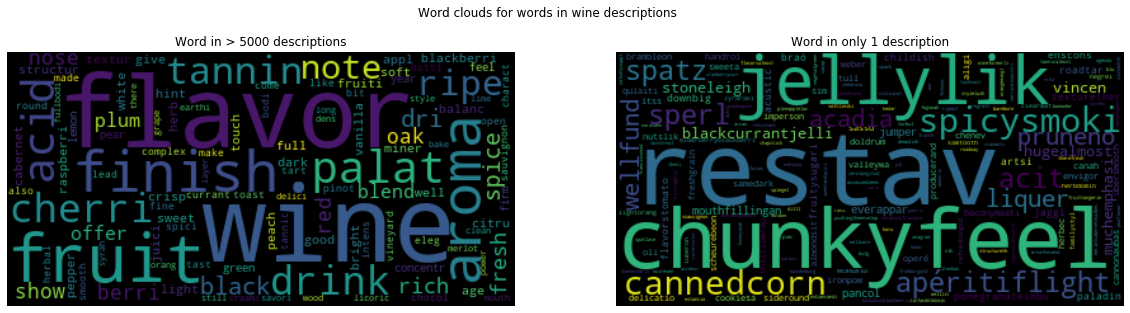

In [49]:
# Plotting the wordclouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Word clouds for words in wine descriptions')

wcloud = WordCloud().generate_from_frequencies(dict([(m, n) for m, n in fdist.items() if n > 5000]))
ax1.imshow(wcloud, interpolation="bilinear")
ax1.axis("off")
ax1.title.set_text('Word in > 5000 descriptions')

wcloud = WordCloud().generate_from_frequencies(dict([(m, n) for m, n in fdist.items() if n == 1]))
ax2.imshow(wcloud, interpolation="bilinear")
ax2.axis("off")
ax2.title.set_text('Word in only 1 description')

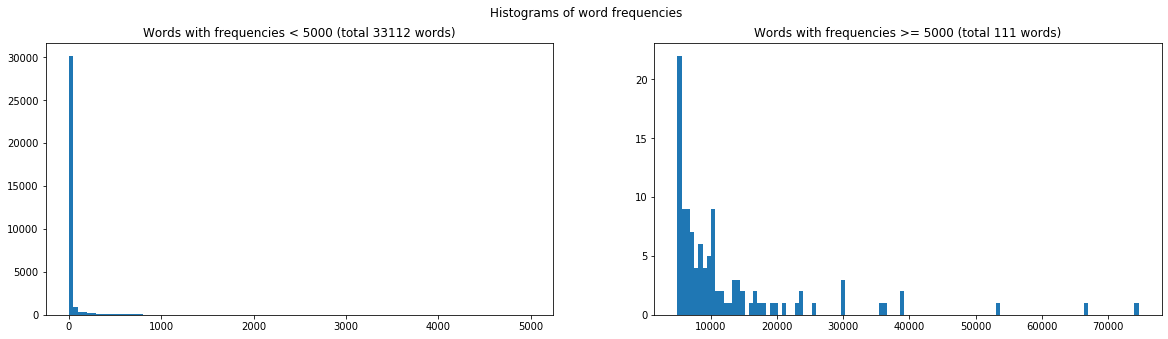

In [50]:
# Plotting the histograms
k = 5000

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,5))
fig.suptitle('Histograms of word frequencies')

ax1.hist(keyword_freq[keyword_freq['frequency'] < k]['frequency'], bins = min(k - 1, 100));
ax1.title.set_text('Words with frequencies < {} (total {} words)'.format(k, keyword_freq[keyword_freq['frequency'] < k]['frequency'].count()))

ax2.hist(keyword_freq[keyword_freq['frequency'] >= k]['frequency'], bins = keyword_freq[keyword_freq['frequency'] >= k]['frequency'].count() - 1);
ax2.title.set_text('Words with frequencies >= {} (total {} words)'.format(k, keyword_freq[keyword_freq['frequency'] >= k]['frequency'].count()))

There are a lot of words appearing in few descriptions. Let's concentrate on more frequent words (expert choice of >=5000 appearances in descriptions) and create dummy variables for them: whether wine description contains the word or not.
(Word count is reduced in order to decrease computational time - 111 words selected)

In [51]:
# Filter words of interest
words_set = set(keyword_freq[keyword_freq['frequency'] >= k]['word_stemmed'])

In [52]:
# Create stemmed word dictionary only of words of interest
words_set_dict = dict()
for key, value in all_words_stemmed_dict.items():
    if value in words_set:
        words_set_dict[key] = value

In [53]:
%%time
# Create dummy columns: 0/1
for i in list(words_set):
    wine_data_with_price['dummy_desc_' + i] = 0
    for key, value in words_set_dict.items():
        if value == i:
            wine_data_with_price['dummy_desc_' + i][wine_data_with_price['description_divided'].apply(lambda x: key in x)] = 1
# 31 sec for 111 words

C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\jekat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jekat\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/index

Wall time: 38.6 s


In [54]:
wine_data_with_price.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,dummy_desc_chocol,dummy_desc_note,dummy_desc_lime,dummy_desc_firm,dummy_desc_still,dummy_desc_delici,dummy_desc_berri,dummy_desc_feel,dummy_desc_year,dummy_desc_power
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown region_1,Unknown region_2,Roger Voss,@vossroger,...,0,0,0,1,1,0,1,0,0,0
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown designation,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0,0,1,0,0,0,0,0,0,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown region_2,Alexander Peartree,Unknown twitter,...,0,1,0,0,0,0,0,0,0,0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0,0,0,0,0,0,0,0,0,0
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Unknown region_2,Michael Schachner,@wineschach,...,0,0,0,0,0,0,0,0,0,0


## 5. Dummies for categorical variables<a class="anchor" id="dummies-for-categorical">
[Back to Table of Contents](#toc)

Will try to include only column with less categories - country.

In [55]:
# Choose suitable categorical columns and create for them dummy variables
categorical_columns = wine_data_with_price.select_dtypes(include = 'object').columns.tolist()
to_remove = ['description', 'designation', 'title', 'winery', 'has_missing_price', 'description_divided', 
             'region_1', 'region_2', 'province'
#              ,'variety', 'taster_name', 'taster_twitter_handle'
            ]
for i in to_remove:
    categorical_columns.remove(i)
categorical_columns

['country', 'taster_name', 'taster_twitter_handle', 'variety']

In [56]:
for i in categorical_columns:
    temp = pd.get_dummies(wine_data_with_price[i], prefix = 'dummy_' + i)
    temp.columns = temp.columns.str.replace(' ', '')
    wine_data_with_price = pd.merge(wine_data_with_price, temp, left_index = True, right_index = True)

In [57]:
wine_data_with_price.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,...,dummy_variety_Xynisteri,dummy_variety_Yapincak,dummy_variety_Zibibbo,dummy_variety_Zierfandler,dummy_variety_Zierfandler-Rotgipfler,dummy_variety_Zinfandel,dummy_variety_Zlahtina,dummy_variety_Zweigelt,dummy_variety_Çalkarası,dummy_variety_Žilavka
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,Unknown region_1,Unknown region_2,Roger Voss,@vossroger,...,0,0,0,0,0,0,0,0,0,0
2,US,"Tart and snappy, the flavors of lime flesh and...",Unknown designation,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0,0,0,0,0,0,0,0,0,0
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Unknown region_2,Alexander Peartree,Unknown twitter,...,0,0,0,0,0,0,0,0,0,0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,...,0,0,0,0,0,0,0,0,0,0
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Unknown region_2,Michael Schachner,@wineschach,...,0,0,0,0,0,0,0,0,0,0


## 6. Predictions<a class="anchor" id="predictions">
[Back to Table of Contents](#toc)

In [58]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

random_state = 20191229

In [59]:
# Helper function
def MAPE(y, yhat, digits = 5):
    ''' Calculate mean average percentage error
    digits: count of digits for rounding'''
    return round(np.mean(abs((y - yhat) / y)), digits)

# From https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [60]:
# Create column name objects
X_columns = ['twitter_follower_count'] + [s for s in wine_data_with_price.columns if 'dummy_' in s]
Y1_columns = 'points'
Y2_columns = 'price'

In [61]:
# Scale columns of interest
scaler = MinMaxScaler()
wine_data_with_price[X_columns] = scaler.fit_transform(wine_data_with_price[X_columns])

In [62]:
# Test/train split: 0.8/0.2
train_df, test_df = train_test_split(wine_data_with_price, test_size = 0.2, random_state = random_state)

### 6.1. Points<a class="anchor" id="points">
[Back to Table of Contents](#toc)

In [63]:
X_train = train_df[X_columns].values
y_train = train_df[Y1_columns].values

X_test = test_df[X_columns].values
y_test = test_df[Y1_columns].values

In [64]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(96780, 888)
(96780,)
(24195, 888)
(24195,)


#### 6.1.1. Linear regression with default settings

In [65]:
learner = LinearRegression()
learner.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [67]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

740728.04346 0.01941


In [68]:
# Check results visually
print(y_test_pred, y_test)

[88.59924316 87.85766602 89.78082275 ... 90.22668457 88.77850342
 88.12786865] [88 88 94 ... 94 95 92]


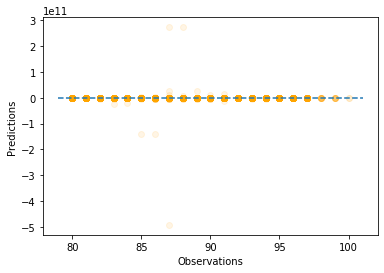

In [69]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.show()

Such a huge MAPE on test data is explained by few points having abnormally high predictions. This needs to be inspected more carefully in case model is chosen for usage.

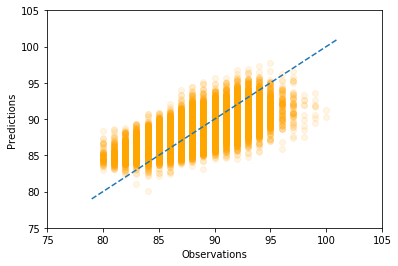

In [70]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(75, 105)
plt.ylim(75, 105)
plt.show()

#### 6.1.2. Stochastic Gradient Descent Regressor with default settings

In [71]:
# Stochastic Gradient Descent: SGDRegressor
learner = SGDRegressor(random_state = random_state)

In [72]:
learner.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25,
             random_state=20191229, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [73]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [74]:
# Check results visually
print(y_test_pred, y_test)

[88.44886979 87.95650885 89.64856739 ... 90.22577452 88.85426963
 87.44649727] [88 88 94 ... 94 95 92]


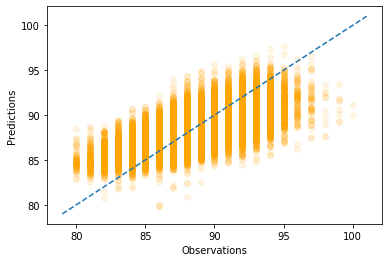

In [75]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.show()

In [76]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

0.01958 0.01957


Valuable result achieved even using default parameters of model: 1.96% mean average percentage error

#### 6.1.3. Stochastic Gradient Descent Regressor: Parameter grid search

In [77]:
# learner = SGDRegressor(random_state = random_state)
# parameter_grid = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
#                   'penalty': ['none', 'l2', 'l1', 'elasticnet']}
# cross_validation = StratifiedKFold(n_splits = 10)
# grid_search = GridSearchCV(learner,
#                            param_grid = parameter_grid,
#                            cv = cross_validation)
# grid_search.fit(X_train, y_train)

In [78]:
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

# grid_search.best_estimator_

In [79]:
# Stochastic Gradient Descent: SGDRegressor
learner = SGDRegressor(loss = 'squared_loss', penalty = 'elasticnet', random_state = random_state)

In [80]:
learner.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=20191229, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [81]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [82]:
# Check results visually
print(y_test_pred, y_test)

[88.61880263 87.93919683 89.7268094  ... 90.08222381 88.68570663
 87.48968423] [88 88 94 ... 94 95 92]


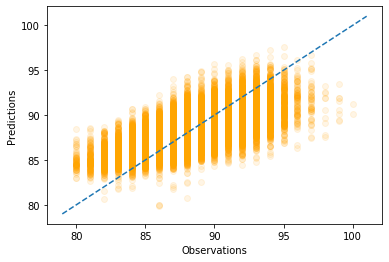

In [83]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.show()

In [84]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

0.01959 0.01957


Model chosen by optimisation of grid search shows the same MAPE results as model with default parameters: 1.96% MAPE.

### 6.2. Price<a class="anchor" id="price">
[Back to Table of Contents](#toc)

In [85]:
X_train = train_df[X_columns].values
y_train = train_df[Y2_columns].values

X_test = test_df[X_columns].values
y_test = test_df[Y2_columns].values

In [86]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(96780, 888)
(96780,)
(24195, 888)
(24195,)


#### 6.2.1. Linear regression with default settings

In [87]:
learner = LinearRegression()
learner.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [88]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [89]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

123312160.27703 0.54847


In [90]:
# Check results visually
print(y_test_pred, y_test)

[47.9921875  21.52929688 43.79101562 ... 34.6171875  38.15820312
 25.51171875] [15. 25. 65. ... 36. 70. 25.]


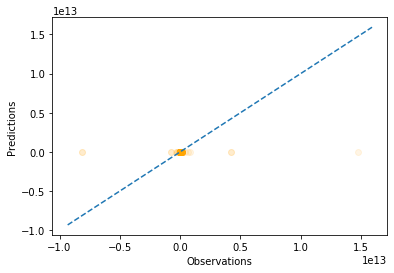

In [91]:
# Check results visually
plt.scatter(y_test_pred, y_test, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.show()

Again, such a huge MAPE on test data is explained by few points having abnormally high predictions. This needs to be inspected more carefully in case model is chosen for usage.

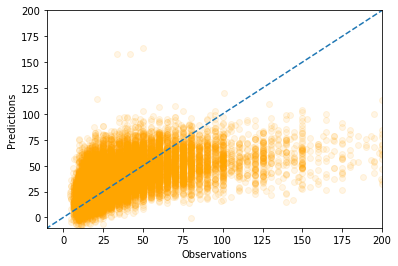

In [92]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(-10, 200)
plt.ylim(-10, 200)
plt.show()

#### 6.2.2. Stochastic Gradient Descent Regressor with default settings

In [93]:
# Stochastic Gradient Descent: SGDRegressor
learner = SGDRegressor(random_state = random_state)

In [94]:
learner.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25,
             random_state=20191229, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [95]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [96]:
# Check results visually
print(y_test_pred, y_test)

[49.18446317 23.37812745 42.48101259 ... 34.43569921 37.36599459
 28.82595062] [15. 25. 65. ... 36. 70. 25.]


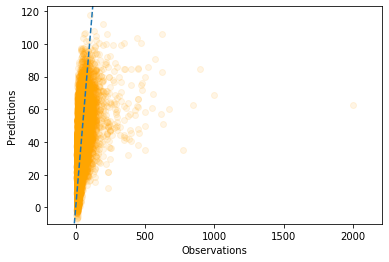

In [97]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.ylim(-10, max(y_test_pred) + 5)
plt.show()

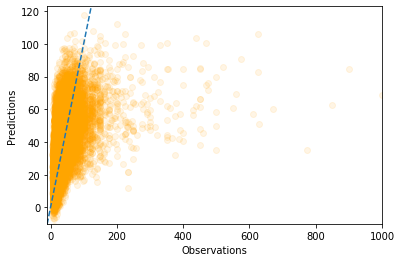

In [98]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(-10, 1000)
plt.ylim(-10, max(y_test_pred) + 5)
plt.show()

In [99]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

0.56119 0.56029


In case of price model is very inprecise: MAPE 56%. Let's see if parameter grid search can improve this result.

#### 6.2.3. Stochastic Gradient Descent Regressor: Parameter grid search

In [100]:
# learner = SGDRegressor(random_state = random_state)
# parameter_grid = {'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
#                   'penalty': ['none', 'l2', 'l1', 'elasticnet']}
# cross_validation = StratifiedKFold(n_splits = 10)
# grid_search = GridSearchCV(learner,
#                            param_grid = parameter_grid,
#                            cv = cross_validation)
# grid_search.fit(X_train, y_train)

In [101]:
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

# grid_search.best_estimator_

In [102]:
# Stochastic Gradient Descent: SGDRegressor
learner = SGDRegressor(loss = 'squared_loss', penalty = 'l2', random_state = random_state)

In [103]:
learner.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25,
             random_state=20191229, shuffle=True, tol=0.001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [104]:
y_test_pred = learner.predict(X_test)
y_train_pred = learner.predict(X_train)

In [105]:
# Check results visually
print(y_test_pred, y_test)

[49.18446317 23.37812745 42.48101259 ... 34.43569921 37.36599459
 28.82595062] [15. 25. 65. ... 36. 70. 25.]


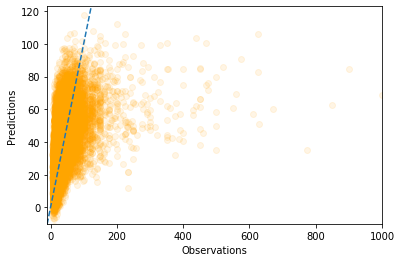

In [106]:
# Check results visually
plt.scatter(y_test, y_test_pred, c = 'orange', alpha = 0.1)
abline(1,0)
plt.xlabel('Observations')
plt.ylabel('Predictions')
plt.xlim(-10, 1000)
plt.ylim(-10, max(y_test_pred) + 5)
plt.show()

In [107]:
# Check MAPE
MAPE_test = MAPE(y_test, y_test_pred)
MAPE_train = MAPE(y_train, y_train_pred)
print(MAPE_test, MAPE_train)

0.56119 0.56029


Model chosen by optimisation of grid search shows the same MAPE results as model with default parameters: 56% MAPE.

## 7. Conclusions and further actions<a class="anchor" id="conclusions">
[Back to Table of Contents](#toc)

Analysis has shown, that wine score points could be predicted with relatively high precision: 1.96% MAPE, meaning, that from description given by taster wine score could be predicted with acceptable error. At the same time, models did not succeeded in price predictions at all: 56% MAPE.

To improve results, following actions could be done:
* Addition of more data from wine descriptions (in analysis only words appearing in at least 5000 descriptions were transformed into features)
* Addition of any different possible features
* Tuning of different models